# Advanced Lane Finding

## Import Packages

In [2]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Camera Calibration and Distortion Correction

In [3]:
def calibrate(img, nx = 9, ny = 6):
    
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    objpoints = []
    imgpoints = []
    objectp = np.zeros((nx * ny, 3), np.float32)
    objectp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for fname in images:    
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret == True:
            objpoints.append(objectp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
    objpoints = dist_pickle["objpoints"]
    imgpoints = dist_pickle["imgpoints"]
    
    ret1, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs


def undistort(img, mtx, dist):
    
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    ret, mtx, dist, rvecs, tvecs = calibrate(images)
    
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistort_img
    

**Test and Visualize Camera Calibration**

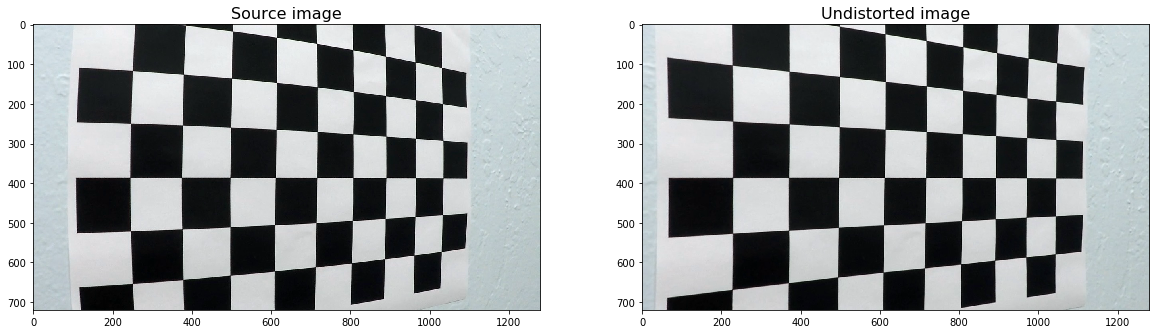

In [6]:
img = cv2.imread('./camera_cal/calibration5.jpg')

images = glob.glob('./camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = calibrate(images)

cal_img = undistort(img, mtx, dist)

def plot_images(img_1, title_1, img_2, title_2, cmap='gray'):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')

plot_images(img, 'Source image', cal_img, 'Undistorted image')

In [8]:
img2 = mpimg.imread('./test_images/test1.jpg')
cal_img2 = undistort(img2, mtx, dist)

mpimg.imsave("writeup_images/test1_undistorted.jpg", cal_img2)

## Threshold Binary Image

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

**Test the functions**

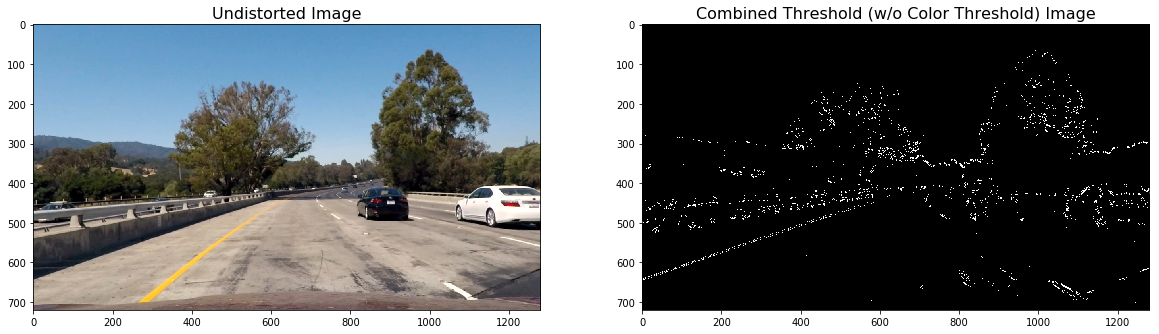

In [5]:
new_img = cv2.imread('./test_images/test1.jpg')
rgb_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
new_undis_img = undistort(rgb_img, mtx, dist)

ksize = 15


gradx = abs_sobel_thresh(new_undis_img, orient='x', sobel_kernel=ksize, thresh=(30, 100))
grady = abs_sobel_thresh(new_undis_img, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(new_undis_img, sobel_kernel=ksize, mag_thresh=(70, 100))
dir_binary = dir_threshold(new_undis_img, sobel_kernel=ksize, thresh=(0.7, 1.3))

combine = np.zeros_like(dir_binary)
combine[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plot_images(new_undis_img, 'Undistorted Image', combine, 'Combined Threshold (w/o Color Threshold) Image')

## Color Threshold

In [6]:
def hls_select(img, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

**Test Color Threshold**

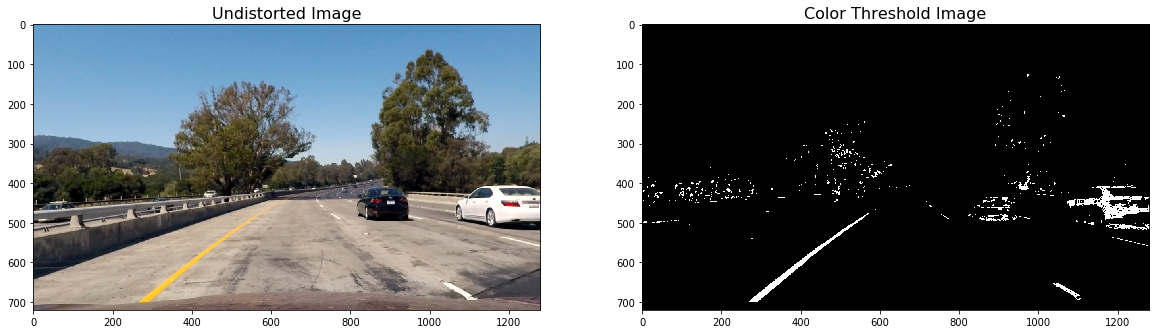

In [7]:
hls_binary = hls_select(new_undis_img, thresh=(170, 255))

plot_images(new_undis_img, 'Undistorted Image', hls_binary, 'Color Threshold Image')

## Combine Thresholds

In [8]:
def thresh_combine(gradx, grady, mag_binary, dir_binary, hls_select, ksize=15):
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_select == 1)] = 1
    
    return combined

**Test Combine Function**

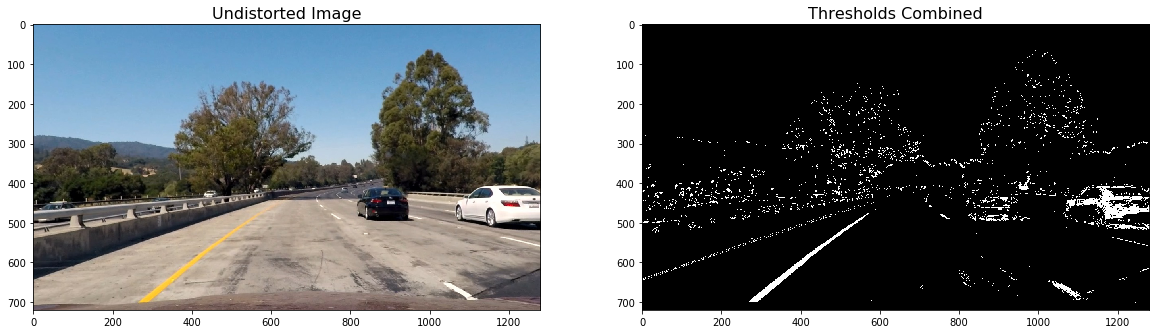

In [9]:
combined = thresh_combine(gradx, grady, mag_binary, dir_binary, hls_binary, ksize=15)

plot_images(new_undis_img, 'Undistorted Image', combined, 'Thresholds Combined')


## Warp Image to Attain Bird's Eye View

In [10]:
def birds_eye(img, src_coordinates=None, dst_coordinates=None):
    
    img_size = (img.shape[1], img.shape[0])
    
    if src_coordinates is None:
        src_coordinates = np.float32([[280, 700], [595, 460], [725, 460], [1125, 700]])
    if dst_coordinates is None:
        dst_coordinates = np.float32([[250, 720], [250, 0], [1065, 0], [1065, 720]])  

    transform = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)

    inv_transform = cv2.getPerspectiveTransform(dst_coordinates, src_coordinates)
    
    warped = cv2.warpPerspective(img, transform, img_size, flags=cv2.INTER_LINEAR)

    return warped, transform, inv_transform


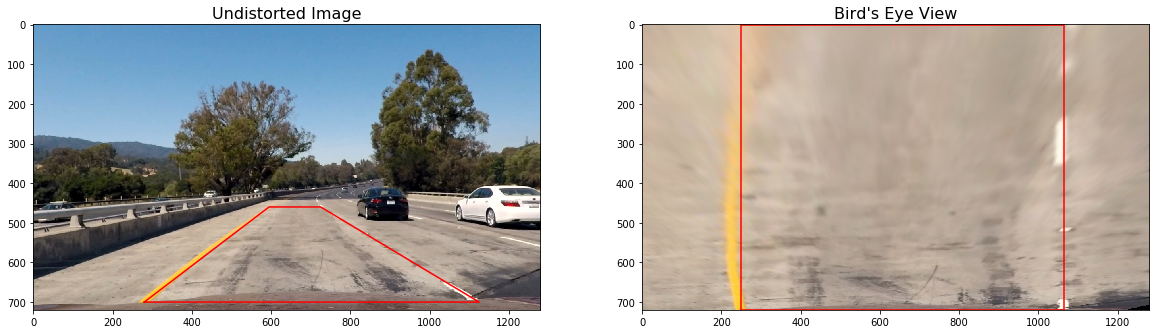

In [11]:
warped_img, _ , Minv  = birds_eye(new_undis_img, None, None)

#plot_images(new_undis_img, 'Undistorted Image', warped_img, 'Bird\'s Eye View')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Image', fontsize=16)
ax1.plot(Polygon(np.float32([[280, 700], [595, 460], [725, 460], [1125, 700]])).get_xy()[:, 0], Polygon(np.float32([[280, 700], [595, 460], [725, 460], [1125, 700]])).get_xy()[:, 1], color='red')
ax1.imshow(new_undis_img)

ax2.set_title('Bird\'s Eye View', fontsize=16)
ax2.plot(Polygon(np.float32([[250, 720], [250, 0], [1065, 0], [1065, 720]])).get_xy()[:, 0], Polygon(np.float32([[250, 720], [250, 0], [1065, 0], [1065, 720]])).get_xy()[:, 1], color='red')
ax2.imshow(warped_img)

## Histogram Function

In [12]:
def hist(img):
    
    bottom_half = img[img.shape[0]//2:,:]

    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

**Test Histogram Function**

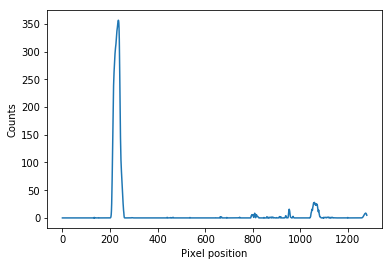

In [13]:
combined_birds_eye = birds_eye(combined)[0]
histogram = hist(combined_birds_eye)

plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram)

## Detect Lines

In [14]:
def find_lane_pixels(binary_warped):
    
    histogram = hist(binary_warped)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    nwindows = 9
    margin = 100
    minpix = 50

    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,1,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,1,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    out_img[lefty, leftx] = [1, 0, 0]
    out_img[righty, rightx] = [0, 0, 1]

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

**Test Detect Lines Functions**

Text(0.5,1,'Detected Lane Lines')

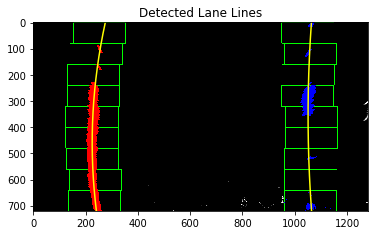

In [15]:
out_img = fit_polynomial(combined_birds_eye)

plt.imshow(out_img)
plt.title('Detected Lane Lines')

In [16]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    
    margin = 100
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,1, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,1, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

**Test Improved Detect Lines Function**

Text(0.5,1,'Lane Lines From Prior')

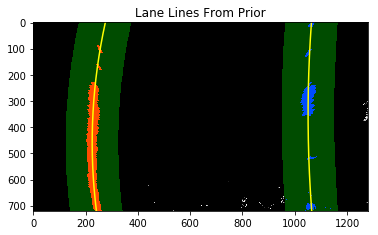

In [17]:
result = search_around_poly(combined_birds_eye)

plt.imshow(result)
plt.title('Lane Lines From Prior')

## Measure Lane Curvature and Vehicle Offset 

In [27]:
def measure_metrics(binary_warped):
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    leftx = leftx[::-1]
    rightx = rightx[::-1]
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    img_shape = binary_warped.shape
    
    mid = img_shape[1]//2
    pos = (leftx[-1] + rightx[-1])/2
    
    offset = (mid - pos) * xm_per_pix
    
    return left_curverad, right_curverad, offset

**Test Metrics Functions**

In [19]:
metrics = measure_metrics(combined_birds_eye)

print('Left lane line curvature:', metrics[0], 'm')
print('Right lane line curvature:', metrics[1], 'm')

print('Vehicle Offset:', metrics[2], 'm')


Left lane line curvature: 692.54828895 m
Right lane line curvature: 1631.22448441 m
Vehicle Offset: -0.0264285714286 m


## Create Lanes Function

In [20]:
def create_lanes(img):
    
    undis_img = undistort(img, mtx, dist)
    
    warped_img, _ , Minv  = birds_eye(undis_img)
    
    color_warped = np.zeros_like(warped_img).astype(np.uint8)
    
    hls_binary = hls_select(undis_img, thresh=(170, 255))

    gradx = abs_sobel_thresh(undis_img, orient='x', sobel_kernel=15, thresh=(30, 100))
    grady = abs_sobel_thresh(undis_img, orient='y', sobel_kernel=15, thresh=(30, 100))
    mag_binary = mag_thresh(undis_img, sobel_kernel=15, mag_thresh=(70, 100))
    dir_binary = dir_threshold(undis_img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    combined = thresh_combine(gradx, grady, mag_binary, dir_binary, hls_binary, ksize=15)
    
    binary_warped = birds_eye(combined)[0]
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))], 'int32')
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))], 'int32')
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warped, [pts], [0, 200, 0])
    
    color_warped[lefty, leftx] = [255, 0, 0]
    color_warped[righty, rightx] = [0, 0, 255]
    
    newwarp = cv2.warpPerspective(color_warped, Minv, (new_img.shape[1], new_img.shape[0]))
    
    result = cv2.addWeighted(undis_img, 1, newwarp, 0.4, 0)

    return result, binary_warped
    

**Test Create Lanes Function**

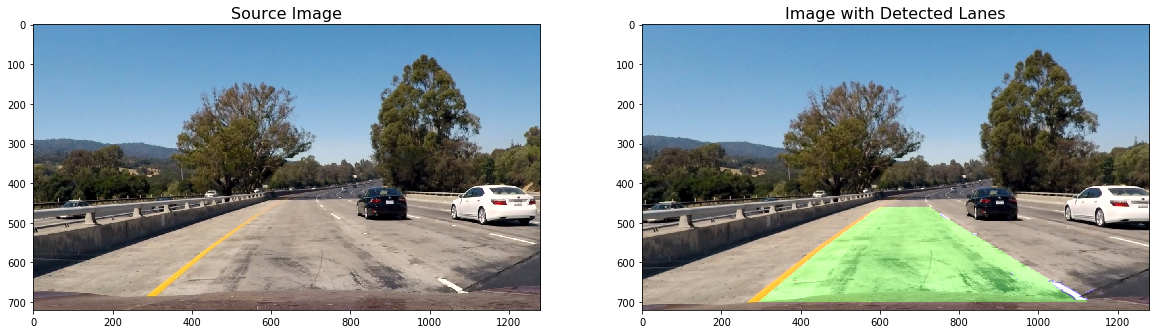

In [21]:
img = mpimg.imread('./test_images/test1.jpg')

result = create_lanes(img)

img = cv2.imread('./test_images/test1.jpg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plot_images(rgb_img, 'Source Image', result[0], 'Image with Detected Lanes')

## Write Metrics to Image

In [22]:
def write_metrics(lanes_img, binary_warped):
    
    metrics = measure_metrics(binary_warped)
    
    out_img = lanes_img.copy()
    
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(metrics[0]), 
                (60, 60), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(metrics[1]), 
                (60, 110), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 5)
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(metrics[2]), 
                (60, 160), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), 5)
    
    return out_img
    
    

**Test Write Metrics Function**

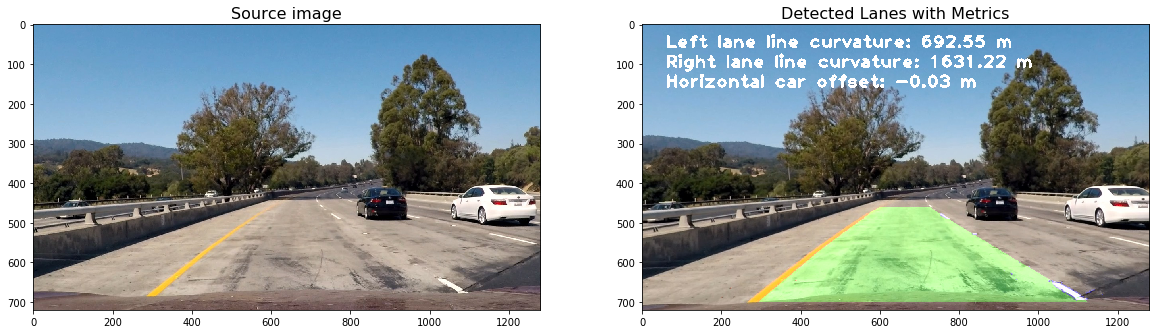

In [23]:
out_img = write_metrics(result[0], combined_birds_eye)

plot_images(rgb_img, 'Source image', out_img, 'Detected Lanes with Metrics')

## Process Image Function

In [24]:
def process_image(img):
    
    result = create_lanes(img)
    
    out_img = write_metrics(result[0], result[1])
    
    return out_img
    

**Run Process Image Function on all Test Images**

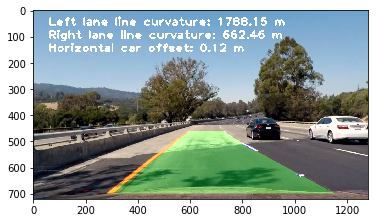

In [25]:
directory = os.listdir("test_images/")
if not os.path.isdir("test_images_output"):
    os.mkdir("test_images_output")

for Img in directory:
    inputImg = mpimg.imread("test_images/" + Img)
    outImg = process_image(inputImg)
    mpimg.imsave("test_images_output/" + Img , outImg)
    plt.imshow(outImg)

In [26]:
white_output = 'videos_output/project_video.mp4'
if not os.path.isdir("videos_output"):
    os.mkdir("videos_output")
    
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video videos_output/project_video.mp4
[MoviePy] Writing video videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [1:11:37<00:03,  3.38s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/project_video.mp4 

CPU times: user 1h 8min 45s, sys: 8.44 s, total: 1h 8min 54s
Wall time: 1h 11min 40s
